In [1]:
# Bootstrap
import os
import sys

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    
if "src" not in sys.path:
    sys.path.insert(0, "src")

## Notebook Description

This notebook demonstrates how to fit and evaluate the custom RBFModel on a synthetic two-dimensional nonlinear surface with mixed curvature dataset, using the fuzzy-means clustering method.

### Dataset description

We use the file `data/smooth_nonlinear_surface.csv`, which contains samples from a synthetic two-dimensional nonlinear surface with mixed curvature.  
The dataset represents a smooth function combining local oscillatory behavior and a global quadratic trend.  
The columns are:

- **x1** — first input coordinate  
- **x2** — second input coordinate  
- **y** — target value defined as  

$$
y = \sin(2\pi x_1)\cos(2\pi x_2) + 0.3\,x_1^2
$$

#### Workflow

    1. Load the dataset from CSV
    2. Normalize inputs and targets (normalization is done outside the model)
    3. Select RBF centers using fuzzy-means (testing mode for this example)
    4. Fit the RBFModel to approximate the noisy sine function
    5. Visualize the learned function and compute error metrics

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from rbf_sa_optimizer.model import RBFModel
from rbf_sa_optimizer.utils import fuzzymeans

In [3]:
# Load sine dataset from CSV
data_path = Path("data/smooth_nonlinear_surface.csv")

data = np.genfromtxt(data_path, delimiter=",", skip_header=1)
print("Raw data shape:", data.shape)

# Columns: t, y_clean, y_noisy
X = data[:, 0:2]           
y = data[:, 2:3] 

print("X shape:", X.shape)
print("y shape:", y.shape)

Raw data shape: (900, 3)
X shape: (900, 2)
y shape: (900, 1)


## Why we normalize the data

Before training the RBF model, we normalize both the input values (`X`) and the
target values (`y`) to the range **[-1, 1]**.

Normalization helps for three reasons:

1. **Stable distances**  
   RBF models use distances between samples and centers.  
   If the input values have very different scales, these distances become
   unreliable and the model behaves poorly.

2. **Smooth training**  
   When all values are in a similar numeric range, the model can fit the data
   more smoothly and with fewer numerical issues.

3. **Cleaner learning signal**  
   The noisy sine wave becomes easier for the model to approximate when both
   `X` and `y` are scaled to a consistent range.

For clarity, the normalization is performed **outside** the RBF model.
The model receives already-normalized data and does not need to know how the
scaling was done.


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Normalize input (X) and output (y) to [-1, 1]
x_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = x_scaler.fit_transform(X)

y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = y_scaler.fit_transform(y)

### Visualization of the a synthetic two-dimensional nonlinear surface with mixed curvature dataset

The following figure visualizes the dataset as a two-dimensional input space and its associated output surface:

- **x1** — first input dimension  
- **x2** — second input dimension  
- **y** — the resulting nonlinear response

This plot provides a visual reference for the function that the RBF model will
attempt to approximate.

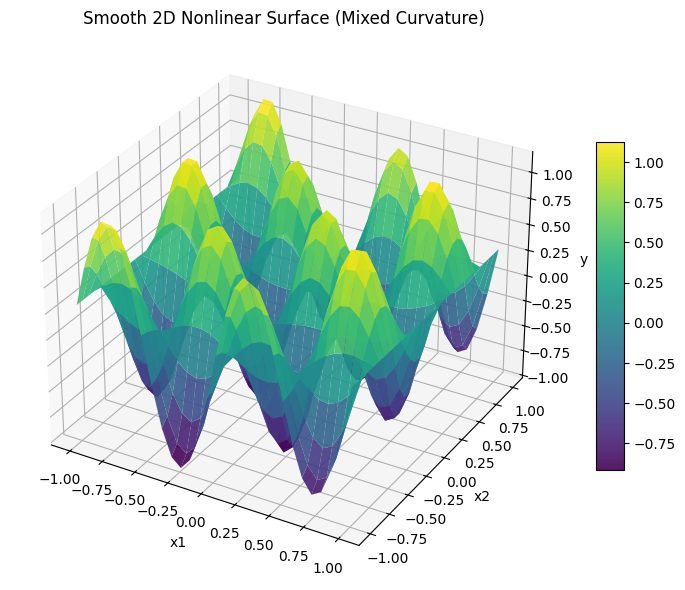

In [5]:
x1 = np.unique(X[:, 0])
x2 = np.unique(X[:, 1])

X1, X2 = np.meshgrid(x1, x2, indexing="xy")

# y is (N, 1) -> flatten then reshape to (len(x2), len(x1))
Y = y.reshape(-1).reshape(len(x2), len(x1))

# Plot surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    X1, X2, Y,
    cmap="viridis",
    linewidth=0,
    antialiased=True,
    alpha=0.9
)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Smooth 2D Nonlinear Surface (Mixed Curvature)")

fig.colorbar(surf, shrink=0.6, aspect=12)
plt.tight_layout()
plt.show()

### What are RBF centers and why do we compute them?

Radial Basis Function (RBF) models use a set of "centers" placed in the input
space to construct a smooth approximation of a function.

Each center corresponds to a Gaussian radial function.  
During training, the model learns how to combine these radial functions to
approximate the target signal.

Why we need centers:

- They define **where** the RBFs are located along the input axis.
- They determine **how locally** or **globally** the model responds to the data.
- They strongly influence the smoothness and accuracy of the final prediction.

In this example we use **fuzzy-means** to select center locations.
This method select centers based on a fuzzy partition of the input space and
automatically determines an appropriate number of RBF centers by ensuring that
all input samples are sufficiently covered.

In [6]:
# Select RBF centers using fuzzy-means
N_PARTITIONS = [12, 12] # you can experiment with this value

centers = fuzzymeans(X_scaled, partitions=N_PARTITIONS)

print("Centers shape:", centers.shape)
unique = np.unique(centers, axis=0)
print("centers:", centers.shape[0], "unique:", unique.shape[0])

Centers shape: (70, 2)
centers: 70 unique: 70


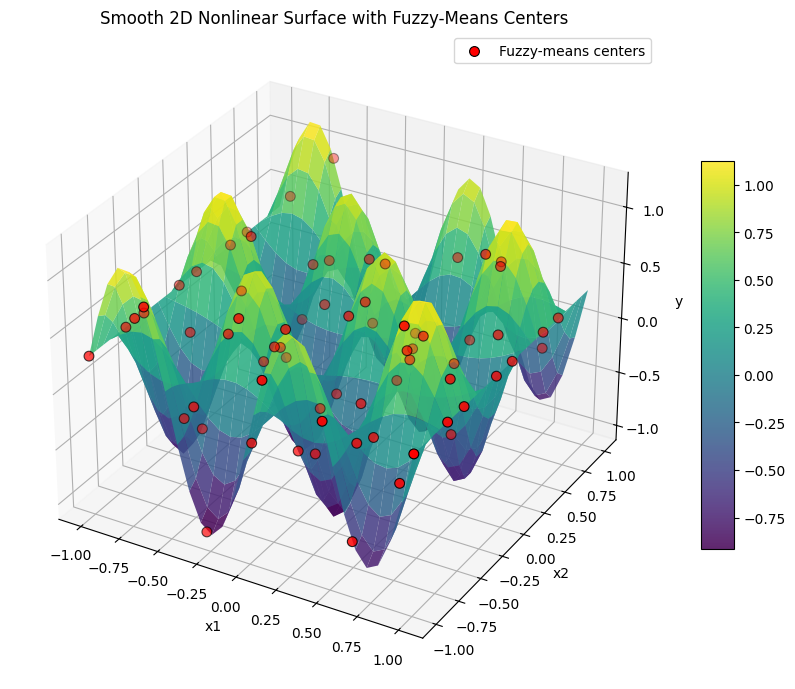

In [7]:
centers_x = x_scaler.inverse_transform(centers)

z_centers = (
    np.sin(2.0 * np.pi * centers_x[:, 0])
    * np.cos(2.0 * np.pi * centers_x[:, 1])
    + 0.3 * centers_x[:, 0] ** 2
)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

# Surface
surf = ax.plot_surface(
    X1, X2, Y,
    cmap="viridis",
    linewidth=0,
    antialiased=True,
    alpha=0.85
)

# Centers overlay
ax.scatter(
    centers[:, 0],
    centers[:, 1],
    z_centers,
    color="red",
    s=50,
    marker="o",
    edgecolor="k",
    linewidth=0.8,
    label="Fuzzy-means centers"
)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Smooth 2D Nonlinear Surface with Fuzzy-Means Centers")

ax.legend()
fig.colorbar(surf, shrink=0.6, aspect=12)

plt.tight_layout()
plt.show()

### Training the RBF model (fit step)

Once the RBF centers have been placed along the input space, the next step is
to **train** the model so that it can approximate the target function.

During training:

1. Each input point is compared to all centers.  
   This produces a set of radial responses (one value per center).

2. These responses form a matrix of features (one row per sample).  
   The model then learns how to combine these features to match the target
   signal as closely as possible.

3. The training process is a simple **least-squares optimization**.  
   The model finds a set of weights that minimize the difference between the
   predicted curve and the noisy sine wave.

In summary, the training step teaches the model how to transform the distances
to the centers into a smooth approximation of the target signal.

In [8]:
# Create and train the RBF model
N_NEIGHBORS = 7  # number of nearest centers for adaptive sigma

model = RBFModel(centers=centers, n_neighbors=N_NEIGHBORS)
model.fit(X_scaled, y_scaled)

print("Model fitted:", model.fitted_)
print("Sigmas shape:", model.sigmas_.shape)
print("Weights shape:", model.weights_.shape)

Model fitted: True
Sigmas shape: (70,)
Weights shape: (71, 1)


### Making predictions with the trained model

After training, the RBF model has learned how to combine the radial basis
functions in order to approximate the target signal.

The **prediction** step simply applies what the model has learned:

1. Each input point is compared to the centers.
2. The radial responses are computed using the learned sigmas.
3. These responses are combined using the trained weights to produce an output.

In practice, this means that the model can now generate a smooth approximation
of the sine wave for any input value.

In [9]:
# Predict the sine signal using the trained model
y_pred_scaled = model.predict(X_scaled)

# Convert predictions back to the original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled)

print("y_pred shape:", y_pred.shape)

y_pred shape: (900, 1)


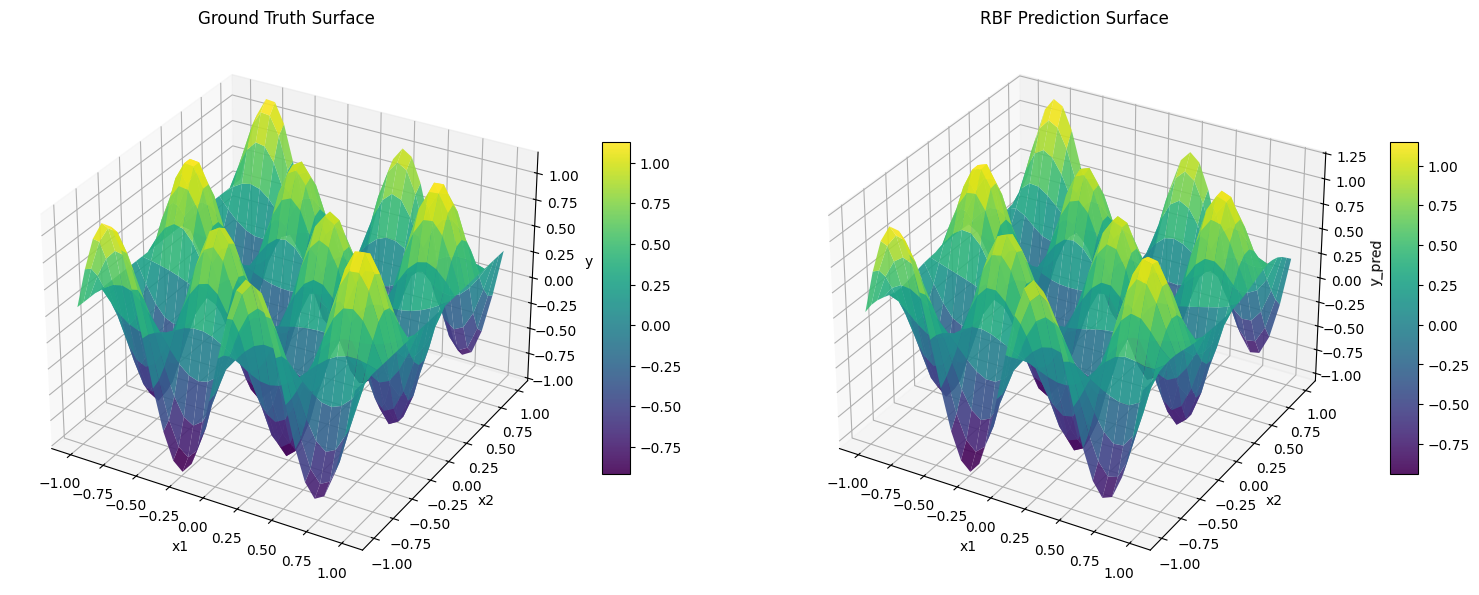

In [10]:
# Flatten grid for prediction

fig = plt.figure(figsize=(16, 6))

# -------- Left: ground truth --------
ax1 = fig.add_subplot(121, projection="3d")

surf1 = ax1.plot_surface(
    X1, X2, Y,
    cmap="viridis",
    linewidth=0,
    antialiased=True,
    alpha=0.9
)

ax1.set_title("Ground Truth Surface")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_zlabel("y")

fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=12)

# -------- Right: prediction --------
ax2 = fig.add_subplot(122, projection="3d")

Y_pred = y_pred.reshape(-1).reshape(len(x2), len(x1))

surf2 = ax2.plot_surface(
    X1, X2, Y_pred,
    cmap="viridis",
    linewidth=0,
    antialiased=True,
    alpha=0.9
)

ax2.set_title("RBF Prediction Surface")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("y_pred")

fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=12)


plt.tight_layout()
plt.show()

### Understanding error metrics

After making predictions, we need a way to measure how close the model’s output
is to the actual target signal. Error metrics provide a simple numerical way to
summarize the model’s performance.

In this notebook we use three common metrics:

- **MSE (Mean Squared Error)**  
  Measures the average of the squared differences between prediction and target.
  Larger errors are penalized more strongly.

- **RMSE (Root Mean Squared Error)**  
  The square root of MSE.  
  It has the same units as the original signal, making it easier to interpret.

- **MAE (Mean Absolute Error)**  
  The average absolute difference between prediction and target.  
  More robust to large outliers than MSE.

In simple terms:  
these metrics tell us **how close the predicted curve is to the true signal**.
Smaller values indicate a better approximation.

In [11]:
# Compute error metrics in the original (unscaled) domain
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)

print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")

MSE  : 0.001073
RMSE : 0.032751
MAE  : 0.025335


## Conclusion

In this notebook we demonstrated the use of fuzzy-means for selecting RBF centers on a two-dimensional nonlinear regression problem.  
By varying the partitioning resolution, we observed a clear and interpretable trade-off between model compactness and approximation accuracy.  
Coarse partitioning leads to underfitting, while finer partitioning progressively captures the local oscillatory structure of the surface.  
At a partitioning of [12,12], the fuzzy-means algorithm achieves high accuracy while maintaining a structured and deterministic center placement.  
These results illustrate how fuzzy-means provides an effective and geometrically interpretable mechanism for controlling RBF model capacity, bridging the gap between compact models and high-fidelity approximations.
